**Names of all group members**:  Giulio Carassai, Alihan Kerestecioglu, Soren Lambreccht,

Follow the template below.

# Exercise 1 (Black-Scholes model)

In [69]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Concatenate, Subtract, Multiply, Lambda, Add
from keras.backend import constant
from keras import optimizers

#from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input, BatchNormalization
import keras.backend as K

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import ncx2

from tensorflow.keras.optimizers import schedules
import keras

# Fix random generation seed for reproducibility
np.random.seed(0)

### Question 1.a

Check that $ S_t = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE.

Since $S>0$, we can apply Itô's lemma on the process $ Y(t) = log (S(t))$, which satisfies regularity requirements. We then get 

\begin{equation}
\begin{align}
d Y_t  = && \frac{1}{S_t} d S_t - \frac{1}{2} \sigma^2 dt  && \\
=  &&  \sigma d W  - \frac{1}{2} \sigma^2 dt && \\
\end{align}
\end{equation}

It then follows that 

\begin{equation}
\begin{align}
\log S(t)  =  && \log S_0 + \int_0^t \sigma d W  - \int_0^t \frac{1}{2} \sigma^2 ds && \\
=  && \log S_0 + \sigma W_t  -  \frac{1}{2} \sigma^2 t  && \\
\end{align}
\end{equation}


Finally, exponentiating on both sides we get the solution:
$$ S(t) = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right) $$

### Question 1.b - Generate dataset

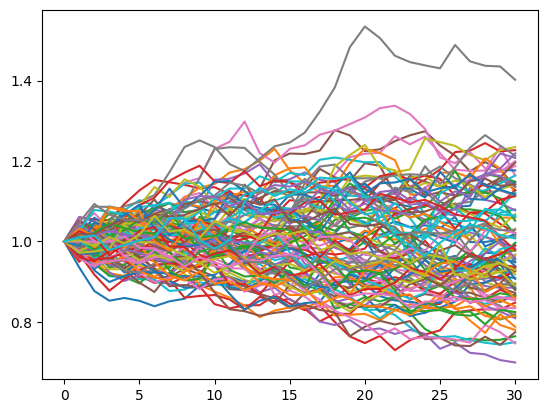

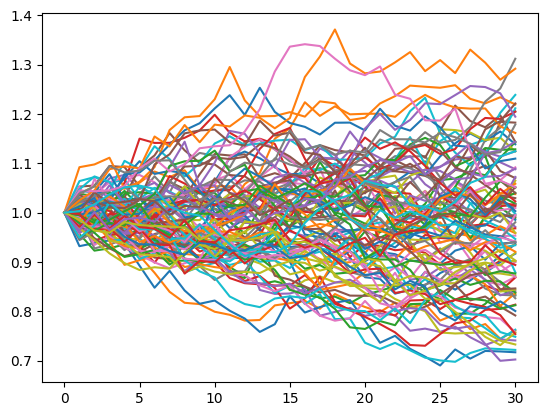

In [70]:
# Generate the training set

# 0. Set parameters:
N = 30                      # Number of periods
s_0 = 1.                    # Initial risky asset price
T = 30/365                  # Call option maturity
sigma = 0.5
strike = 1.

def generate_paths(n_paths, s0 = s_0, T = T, N = N, sigma = sigma):
    x = []  # list of paths
    x.append(np.zeros(n_paths))
    x.append(s0*np.ones(n_paths))

    for j in range(N):
        x.append(x[-1]*np.exp(-sigma**2*T/(2*N)+sigma*(T/N)**0.5*np.random.normal(size=n_paths)))   

    return x

m = 10**5
x_train = generate_paths(m)
y_train = np.zeros(m)

# # plot

paths = np.zeros((m, N+1))
for j in range(N+1):
    paths[:, j] = x_train[j+1]

plt.plot(paths.T[:, :100])
plt.show()

# Generate the test set

m_test = 10**4
x_test = generate_paths(m_test)
y_test = np.zeros(m_test)

# plot
paths = np.zeros((m_test, N+1))
for j in range(N+1):
    paths[:, j] = x_test[j+1]

plt.plot(paths.T[:, :100])
plt.show()

### Question 1.c - Model implementation

In [41]:
# Implement the deep hedging model

# Number of hidden nodes in each hidden layer
n_hidden_nodes = 20  

# We need N networks, we store them in a list
networks = []

for j in range(N):
    
    model = Sequential()

    model.add(BatchNormalization())
    
    # Add hidden layer
    model.add(Dense(n_hidden_nodes, 
                      activation='relu',
                      kernel_initializer='glorot_normal',
                      bias_initializer='zeros'))
    
    # Add hidden layer
    model.add(Dense(n_hidden_nodes, 
                      activation='relu',
                      kernel_initializer='glorot_normal',
                      bias_initializer='zeros'))
    
        # Add hidden layer
    model.add(Dense(n_hidden_nodes, 
                      activation='relu',
                      kernel_initializer='glorot_normal',
                      bias_initializer='zeros'))

    # Add hidden layer
    model.add(Dense(n_hidden_nodes, 
                      activation='relu',
                      kernel_initializer='glorot_normal',
                      bias_initializer='zeros'))

    # Add the output layer (notice the linear activation)
    model.add(Dense(1, activation='linear',
                          kernel_initializer='glorot_normal',
                          bias_initializer='zeros'))

    networks.append(model)
    
# Define as inputs the first two features of the dataset
zeros = Input(shape=(1,))
price = Input(shape=(1,))

inputs = [zeros, price]

def payoff_function(x, strike):
    return K.relu(x-strike)

p = np.mean(payoff_function(x_train[-1], strike))

# Initialize the hedge gain to zero
hedge_gain = zeros

for j in range(N):
    # compute the new hedging strategy
    strategy = networks[j](price)

    # get next price and add it to the list of inputs
    new_price = Input(shape=(1,))
    inputs.append(new_price)
    
    # compute gain from new hedging strategy
    hedge_gain = Add()([hedge_gain, Multiply()([strategy, Subtract()([new_price, price])])])
    
    # update price
    price = new_price

# Compute payoff on last price
payoff = Lambda(lambda x: payoff_function(x, strike))(price)

# Compute model output
output = Subtract()([payoff, hedge_gain])
output = Lambda(lambda x: x - p)(output)

# Instantiate model
deep_hedging_model = Model(inputs=inputs, outputs=output)

# You may use and edit the code shown in demo.ipynb

### Question 1.d - Model training

In [42]:
# Implement the payoff function

def payoff_function(x, strike):
    return K.relu(x-strike)

# Implement a function that returns the Black-Scholes price of a call option with given strike

def BS_price(strike, s0 = s_0, T = T, sigma = sigma, r = 0.):
    d1 = (np.log(s0/strike) + (sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return s0*norm.cdf(d1) - strike*np.exp(-r*T)*norm.cdf(d2)

print("sanity check: montecarlo risk neutral price =", np.mean(payoff_function(x_train[-1], strike)))

# Train the model

initial_learning_rate = 0.01
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100_000,
    decay_rate=0.96,
    staircase=True)

optimizer = optimizers.Adam(learning_rate=0.01)

# We define the squared loss
def custom_loss(y_true, y_pred):
    return (y_true[:, 0] - y_pred[:, 0])**2

deep_hedging_model.compile(optimizer=optimizer,
                           loss=custom_loss)

deep_hedging_model.fit(x=x_train,
                       y=y_train, 
                       epochs=20,
                       verbose=True,
                       batch_size=100)

sanity check: montecarlo risk neutral price = 0.05729470668392321
Epoch 1/20


2023-12-06 22:20:30.878345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 141s 125ms/step - loss: 2.3006e-04
Epoch 2/20
1000/1000 [==============================] - 116s 116ms/step - loss: 1.5724e-04
Epoch 3/20
1000/1000 [==============================] - 116s 115ms/step - loss: 1.5215e-04
Epoch 4/20
1000/1000 [==============================] - 115s 115ms/step - loss: 1.4502e-04
Epoch 5/20
1000/1000 [==============================] - 115s 115ms/step - loss: 1.4668e-04
Epoch 6/20
1000/1000 [==============================] - 113s 113ms/step - loss: 1.4287e-04
Epoch 7/20
1000/1000 [==============================] - 112s 112ms/step - loss: 1.4089e-04
Epoch 8/20
1000/1000 [==============================] - 115s 115ms/step - loss: 1.3677e-04
Epoch 9/20
1000/1000 [==============================] - 115s 115ms/step - loss: 1.3930e-04
Epoch 10/20
1000/1000 [==============================] - 114s 114ms/step - loss: 1.3699e-04
Epoch 11/20
1000/1000 [==============================] - 113s 113ms/step - loss: 1.3811e-04
Epoch 12

### Question 1.e - Model check

313/313 [==============================] - 12s 40ms/step


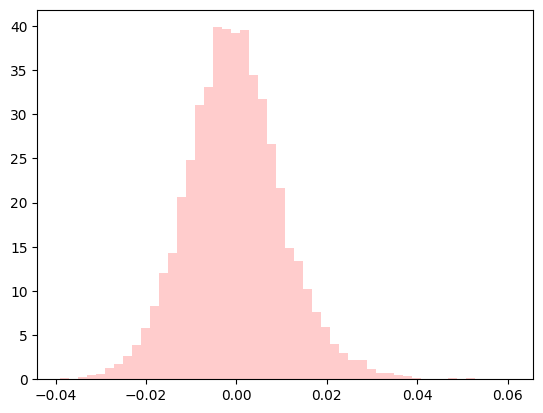

Mean hedging losses:  -0.00027531778
Std hedging losses:  0.010659504


In [71]:
# Evaluate the hedging losses on the test set

hedge_losses = deep_hedging_model.predict(x_test)

# Plot the hedging losses and print mean and standard deviation

plt.hist(hedge_losses, bins = 50, density=True, alpha=0.2, color='red')
plt.show()

print('Mean hedging losses: ', np.mean(hedge_losses))
print('Std hedging losses: ', np.std(hedge_losses))

A few questions for you to consider...

Have you trained the model well?
- Are the losses centered on zero?
- Is the standard deviation sufficiently small with respect to the risk-neutral option price?

How can you improve performance?
- try a different activation function, 
- change the networks' architectures (more/less hidden neurons, more/less hidden layers)
- reduce/increase the learning rate, 
- use a learning rate scheduler (see https://keras.io/api/optimizers/learning_rate_schedules/)
- implement regularization (https://keras.io/api/layers/regularizers/)
- implement batch-normalization (https://keras.io/api/layers/normalization_layers/batch_normalization/)
- change optimizer
- ...

### Question 1.f - Analytical hedging strategies

Compute the analytical hedging strategies:
According to the BS we have that for a call option $V(s) = C_t(T, S_t = s) $. Then it follows that 
$$ H^{\text{BS}}_t(s) = \frac{\partial V(s)}{\partial s} =  \Phi(d_1) + \frac{1}{\sigma \sqrt{T-t}} K \phi(d_1) - e^{-r(T-t)} K \phi(d_2) \frac{K}{s \sigma \sqrt{T-t}} $$
where $d_1$, $d_2$ are the Black-Scholes formula factors.

Empirical loss of the analytical hedging strategies on the test set: -0.02237394382194238


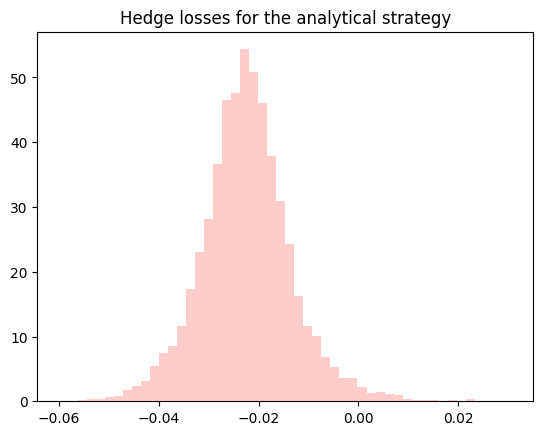

In [72]:
# Implement the formula you found

def analytical(s, K, T, t, r, sigma):
  td = T-t
  d1 = (np.log(s/K) + (r + sigma**2/2)*td) / (sigma * np.sqrt(td))
  d2 = d1 - sigma * np.sqrt(td)
  return norm.cdf(d1) + norm.pdf(d1) * K / (sigma * np.sqrt(td)) - K * np.exp(-r * td) * norm.pdf(d2) * K / (s * sigma * np.sqrt(td))

# Evaluate the losses of the analytical hedging strategies on the test set

loss = np.zeros(m_test)
for i in range(0, m_test):
  s = np.zeros(N)
  for j in range(0,N):
    s[j] = analytical(x_test[j+1][i], strike, T, j/365, 0, sigma) * (x_test[j+2][i] - x_test[j+1][i])
  loss[i] = (max(x_test[N+1][i] - strike, 0) - p - sum(s))

print("Empirical loss of the analytical hedging strategies on the test set:", (1/m_test) * sum(loss))

plt.hist(loss, bins = 50, density=True, alpha=0.2, color='red')
plt.title("Hedge losses for the analytical strategy")
plt.show()

How does your deep hedging model compare with the analytical solution?
- If it's worse, you must improve its performance (see above)

### Question 1.g - Comparison with the analytical hedging strategies

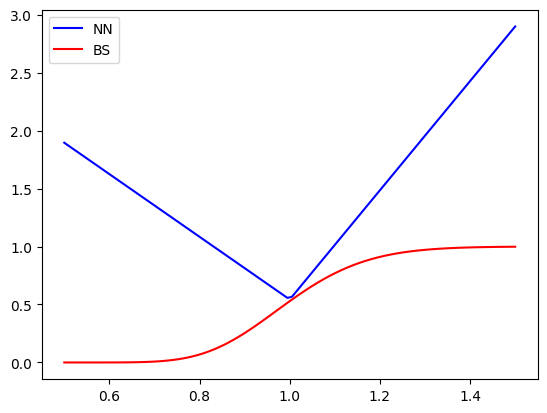

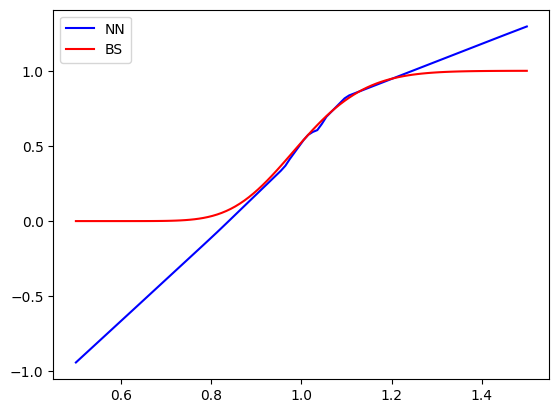

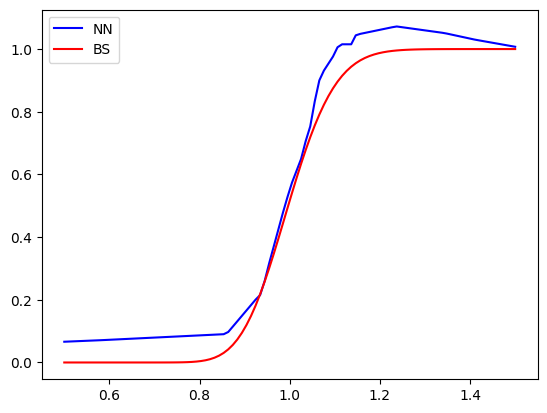

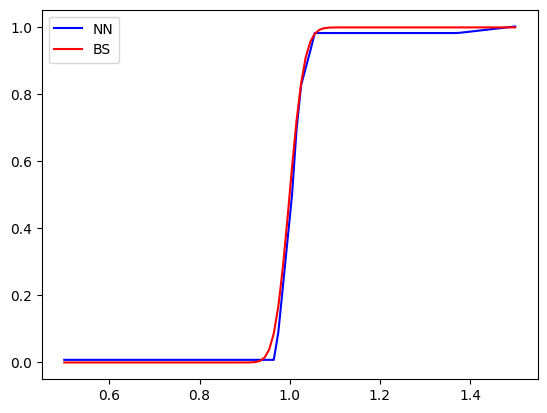

In [44]:
# Plot both the neural network strategies and the analytical hedging strategies

prices = np.linspace(0.5, 1.5, 100).reshape(-1, 1)

for j in [0, 10, 20, 29]:

    plt.plot(prices, networks[j](prices), "blue", label = "NN")
    plt.plot(prices, analytical(prices, strike, T, j/365, 0, sigma), "red", label = "BS")
    plt.legend(loc="upper left")
    plt.show()

- For what times $t_j$ are the two functions most similar? 
- Why?

The performance of the functions improves with the progression of time steps. This is likely because as we approach the final time step, predicting whether the option will be exercised becomes less uncertain, making it easier to estimate the hedging position.

# Exercise 2 (Heston model)

### Question 2.a - Generate the dataset

In [46]:
# Implement simulation of Cox-Ingersoll-Ross process

N = 30
s0 = 1.
T = 30/365
rho = -0.3
t_alpha = 4.
b = 0.5
v0 = 0.5
sigma = 1.

def generate_V(n_paths, T = T, N = N, sigma = sigma, t_alpha = t_alpha, v0 = v0):
    
    c = sigma**2/(4*t_alpha)*(1-np.exp(-t_alpha*T/N))
    dof = 4*t_alpha*b/sigma**2
    V = []
    V.append(np.ones(n_paths)*v0)

    for j in range(N):
        nc_param = np.exp(-t_alpha*T/N) * V[-1] / c
        C = ncx2.rvs(dof, nc_param, size = n_paths)
        V.append(c * C)  

    return V

# Implement Boadie-Kaya scheme

def generate_S(n_paths, V, T = T, N = N, sigma = sigma, t_alpha = t_alpha, rho = rho, s0 = s0):

    S = []
    S.append(np.ones(n_paths) * s0)
    for i in range(0, N):
        Z = np.random.normal(size=n_paths)
        S.append(S[-1]*np.exp(rho/sigma*(V[i+1]-V[i]-t_alpha*b*T/N)+(t_alpha*rho/sigma-0.5) * V[i]*T/N+np.sqrt((1-rho**2)*V[i]*T/N)*Z))
    
    return S

# Generate the training set

m = 10**5
V_train = generate_V(m)
S_train = generate_S(m, V_train)
y_train = np.zeros(m)

# Generate the test set

m_test = 10**4
V_test = generate_V(m_test)
S_test = generate_S(m_test, V_test)
y_test = np.zeros(m_test)

### Question 2.b - Model implementation

In [56]:
# Implement the deep hedging model

# You may edit the code shown in demo.ipynb 

# In particular you must:
# - add one more input to the hedging strategies' networks
# - define your model in such a way as to minimize the loss function in Equation (5)

def hedging_model(alpha):
    # Number of hidden nodes in each hidden layer
    n_hidden_nodes_layer = 20

    # We need N networks, we store them in a list
    networks_price = []

    for j in range(N):

        model_price = Sequential()

        model.add(BatchNormalization())

        # Input layer with two inputs
        dense1 = Dense(n_hidden_nodes_layer,
                       input_shape=(2,),
                       activation="relu",
                       use_bias=True,
                       name="Network"+str(j)+"_hidden_layer1")
        model_price.add(dense1)

        # Add hidden layer
        model_price.add(Dense(n_hidden_nodes_layer,
                              activation='relu',
                              kernel_initializer='glorot_normal',
                              bias_initializer='zeros',
                              ))

        # Add the output layer (notice the linear activation)
        model_price.add(Dense(1, activation='linear',
                              kernel_initializer='glorot_normal',
                              bias_initializer='zeros'))

        networks_price.append(model_price)

    # Define as inputs the first two features of the dataset
    price = Input(shape=(1,), name="Price0")
    price_inputs = [price]
    volatility = Input(shape=(1,), name="Volatility0")
    volatility_inputs = [volatility]

    # Initialize the hedge gain to zero
    hedge_gain = tf.zeros(shape=(1,))

    for j in range(N):

        strategy = networks_price[j](keras.layers.Concatenate(axis = 1)([price, volatility]))

        # get next price and add it to the list of prices
        new_price = Input(shape=(1,), name="Price"+str(j+1))
        price_inputs.append(new_price)

        # compute gain from new hedging strategy
        hedge_gain = Add()([hedge_gain, Multiply()([strategy, Subtract()([new_price, price])])])

        # get next volatility and add to list of volatilities
        new_volatility = Input(shape=(1,), name="Volatility"+str(j+1))
        volatility_inputs.append(new_volatility)

        # update price and volatility
        price = new_price
        volatility = new_volatility

    # Define parameter w
    ones = tf.ones_like(price)
    w = Dense(1, activation='linear',
              kernel_initializer='glorot_normal',
              bias_initializer='glorot_normal', name="w")(ones)

    # Compute payoff on last price
    payoff = Lambda(lambda x: payoff_function(x, strike), name="Payoff")(price)

    # Compute CVaR
    x = Subtract()([payoff, hedge_gain])
    x = Subtract()([x, w])
    x = Lambda(lambda x: (1/(1-alpha))*K.relu(x), name="l_alpha")(x)
    cvar = Add()([w, x])

    inputs = [price_inputs, volatility_inputs]
    outputs = Concatenate()([cvar, payoff, hedge_gain])
    # Instantiate model
    deep_hedging_model = Model(inputs=inputs, outputs=outputs)

    return(deep_hedging_model)


optimizer = optimizers.Adam(learning_rate=0.001)

def custom_loss(y_true, y_pred):
    return K.mean(-y_true[:, 0] + y_pred[:, 0])

model_5 = hedging_model(0.5)
model_5.compile(optimizer=optimizer, loss=custom_loss)

model_99 = hedging_model(0.99)
model_99.compile(optimizer=optimizer, loss=custom_loss)

### Question 2.c - Model training

In [57]:
# Train two models for alpha = 0.5, 0.99

n_epochs = 30
batch_size = 1_000

model_5.fit(x=[S_train, V_train],
                       y=y_train,
                       epochs=n_epochs,
                       verbose=True,
                       batch_size=batch_size,
                       validation_data = ([S_test, V_test], y_test))

model_99.fit(x=[S_train, V_train],
                       y=y_train,
                       epochs=n_epochs,
                       verbose=True,
                       batch_size=batch_size,
                       validation_data = ([S_test, V_test], y_test))

Epoch 1/30


2023-12-06 23:16:55.727413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.8363

2023-12-06 23:17:13.982389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 23s 150ms/step - loss: 0.8363 - val_loss: 0.7369
Epoch 2/30
100/100 [==============================] - 7s 73ms/step - loss: 0.6355 - val_loss: 0.5374
Epoch 3/30
100/100 [==============================] - 6s 63ms/step - loss: 0.4349 - val_loss: 0.3399
Epoch 4/30
100/100 [==============================] - 6s 61ms/step - loss: 0.2410 - val_loss: 0.1555
Epoch 5/30
100/100 [==============================] - 6s 61ms/step - loss: 0.1285 - val_loss: 0.1175
Epoch 6/30
100/100 [==============================] - 6s 62ms/step - loss: 0.1141 - val_loss: 0.1112
Epoch 7/30
100/100 [==============================] - 6s 62ms/step - loss: 0.1097 - val_loss: 0.1081
Epoch 8/30
100/100 [==============================] - 6s 62ms/step - loss: 0.1068 - val_loss: 0.1058
Epoch 9/30
100/100 [==============================] - 6s 65ms/step - loss: 0.1046 - val_loss: 0.1034
Epoch 10/30
100/100 [==============================] - 6s 59ms/step - loss: 0.1026 - val_loss: 0.101

2023-12-06 23:20:15.209203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-06 23:20:34.345806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


### Question 2.d - Compare prices

In [63]:
# Print the three prices. 

def predict_price(model, S, V):
    payoff = model.predict([S, V])[:,1]
    hedge_gain = model.predict([S, V])[:,2]
    return payoff - hedge_gain

pred_price_5 = predict_price(model_5, S_train, V_train)
pred_price_99 = predict_price(model_99, S_train, V_train)

print('price alpha = 0.5: ', np.mean(pred_price_5))
print('price alpha = 0.99: ', np.mean(pred_price_99))
p = np.mean(payoff_function(S_train[-1], strike))
print('Risk neutral price:', p)

# What do you notice?

print("we can therefore notice that the prices increase as alpha increases, since higher alpha means higher risk aversion, and therefore higher prices")


3125/3125 [==============================] - 75s 24ms/step
price alpha = 0.5:  0.079849936
price alpha = 0.99:  0.07991862
Risk neutral price: 0.07936899775938332
we can therefore notice that the prices increase as alpha increases, since higher alpha means higher risk aversion, and therefore higher prices


### Question 2.d - Model check

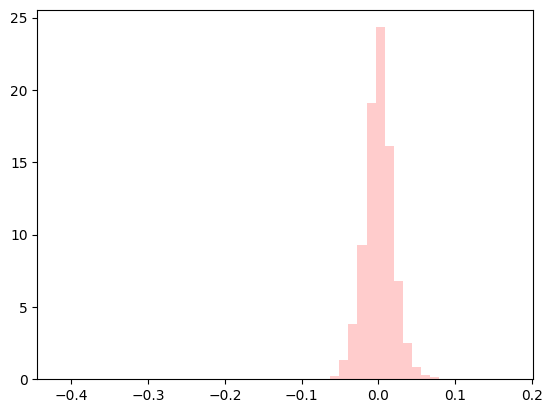

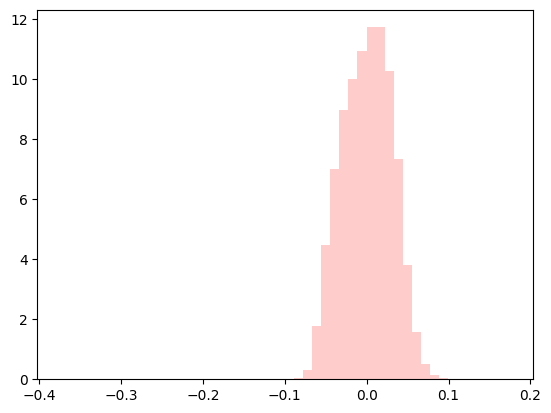

Mean hedge losses:  0.0004809373
Std hedge losses:  0.01891565
Mean hedge losses:  0.0005496212
Std hedge losses:  0.029965855
CVaR at level 0.5 for alpha = 0.5: 0.014599894
CVaR at level 0.5 for alpha = 0.99: 0.02528796
CVaR at level 0.99 for alpha = 0.5: 0.06147262
CVaR at level 0.99 for alpha = 0.99: 0.07361846


In [67]:
# Evaluate the hedging losses for the two models on the test set

hedge_losses_5 = pred_price_5 - p
hedge_losses_99 = pred_price_99 - p

# Implement a function that returns the empirical CVaR at level alpha given a vector of realizations

# Hint: the empirical CVaR is just the CVaR of the empirical distribution

def CVaR(alpha, x):
  VaR = np.quantile(x, alpha)
  return np.mean([y for y in x if y >= VaR])

# Plot the hedging losses and print their empirical mean, standard deviation and CVaR for alpha = 0.5, 0.99 for both models

plt.hist(hedge_losses_5, bins = 50, density=True, alpha=0.2, color='red')
plt.show()

plt.hist(hedge_losses_99, bins = 50, density=True, alpha=0.2, color='red')
plt.show()

print('Mean hedge losses: ', np.mean(hedge_losses_5))
print('Std hedge losses: ', np.std(hedge_losses_5))

print('Mean hedge losses: ', np.mean(hedge_losses_99))
print('Std hedge losses: ', np.std(hedge_losses_99))

print("CVaR at level 0.5 for alpha = 0.5:" ,CVaR(0.5, hedge_losses_5))
print("CVaR at level 0.5 for alpha = 0.99:" ,CVaR(0.5, hedge_losses_99))
print("CVaR at level 0.99 for alpha = 0.5:" ,CVaR(0.99, hedge_losses_5))
print("CVaR at level 0.99 for alpha = 0.99:" ,CVaR(0.99, hedge_losses_99))